# Miniproyecto #3: Redes neuronales artificiales (ANN)


**Autores:**
*   Jorge Sebastián Arroyo Estrada CC. 1193482707
*   César Augusto Montoya Ocampo CC. 1036681523

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

---

## Librerías

In [110]:
import json
import os
import pickle
from datetime import datetime, timedelta
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scikeras.wrappers import KerasClassifier
import sklearn.metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from keras import Input
from keras.layers import Dense
from keras.models import Sequential

## Globales

In [89]:
# Database files paths
DB_BASE_PATH = "../02_features/"
RESOLUTIONS = 2 * [64, 128]
DB_NAMES = [
    f"DB {RESOLUTIONS[i]}×{RESOLUTIONS[i]}{' PCA' if i >= 2 else ''}" for i in range(4)
]
DB_PATHS = [
    f"{DB_BASE_PATH}{'features' if i < 2 else 'pca'}_{RESOLUTIONS[i]}.csv"
    for i in range(4)
]
DB_DICT = {name: path for name, path in zip(DB_NAMES, DB_PATHS)}

# Classes to labels mapping file path
LABELS_PATH = f"{DB_BASE_PATH}labels.csv"

# Results folder
RESULTS_FOLDER = "./ann_results/"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [135]:
# Global parameters
RANDOM_STATE = 150
K = 5

NEURONS = [2**i for i in range(4, 9)]
ACTIVATION_FNS = ["relu", "leaky_relu", "tanh"]
ACTIVATIONS = [list(combo) for n in range(1, 3) for combo in product(ACTIVATION_FNS, repeat=n)]

# Function to create model, required for KerasClassifier
def create_model(neurons, activations, input_dim, output_dim, loss="binary_crossentropy", optimizer="adam"):
    """
    Dynamically creates a Keras Sequential model.
    
    Parameters:
        hidden_layers (int): Number of hidden layers.
        neurons (int): Number of neurons in each hidden layer.
        activation (str): Activation function for the layers.
        optimizer (str): Optimizer for compiling the model.
    
    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()
    
    model.add(Input(shape=(input_dim,)))
    
    # Hidden layers
    for i, activation in enumerate(activations):
        model.add(Dense(neurons//(2**i), activation=activation))
        
    # Output layer 
    model.add(Dense(units=output_dim, activation="softmax"))
    
    # Compile model
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

ESTIMATOR = KerasClassifier(model=create_model, verbose=0)
PARAM_GRID = {
    "model__neurons": NEURONS,
    "model__activations": ACTIVATIONS,
    "model__input_dim": None,
    "model__output_dim": None,
    "model__optimizer": ["adam"],
    "model__loss": ["sparse_categorical_crossentropy"],
}

SCORE_METRICS = {
    "accuracy": make_scorer(accuracy_score),
    "precision_weighted": make_scorer(precision_score, average="weighted"),
    "recall_weighted": make_scorer(recall_score, average="weighted"),
    "f1_weighted": make_scorer(f1_score, average="weighted"),
}
MAIN_SCORE_METRIC = list(SCORE_METRICS.keys())[-1]

## ANN

In [136]:
def load_and_preprocess_data(path: str) -> tuple[np.ndarray, pd.Series]:
    """
    Load data from a CSV file, separate features and labels,
    and apply standard scaling to features.

    Parameters:
        path (str): Path to the CSV file

    Returns:
        Tuple[np.ndarray, pd.Series]: Scaled features and target labels
    """
    df = pd.read_csv(path)

    # Randomly shuffle the rows of the DataFrame
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Standarize features
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled, y


def load_label_mapping(label_path: str) -> dict[int, str]:
    """
    Load label mappings from CSV, mapping class numbers to readable names.

    Parameters:
        label_path (str): Path to the label CSV file

    Returns:
        Dict[int, str]: Dictionary mapping class numbers to readable labels
    """
    label_df = pd.read_csv(label_path)
    label_mapping = dict(zip(label_df["Class"], label_df["label"]))
    return label_mapping


def load_results(name):
    """
    Tries to load
    """
    try:
        # Load scores
        with open(f"{RESULTS_FOLDER}{name}_train_results.json", "r") as f:
            train_scores = json.load(f)
        with open(f"{RESULTS_FOLDER}{name}_validation_results.json", "r") as f:
            validation_scores = json.load(f)
        with open(f"{RESULTS_FOLDER}{name}_test_results.json", "r") as f:
            test_scores = json.load(f)

        # Load inference time
        with open(f"{RESULTS_FOLDER}{name}_inference_time.txt", "r") as f:
            time_str = f.read().strip()
            time_obj = datetime.strptime(time_str, "%H:%M:%S.%f")
            inference_time = timedelta(
                hours=time_obj.hour,
                minutes=time_obj.minute,
                seconds=time_obj.second,
                microseconds=time_obj.microsecond,
            )

        # Load the best estimator using pickle
        with open(f"{RESULTS_FOLDER}{name}_best_estimator.pkl", "rb") as f:
            best_estimator = pickle.load(f)

        return (
            best_estimator,
            train_scores,
            validation_scores,
            test_scores,
            inference_time,
        )

    except OSError:
        return None


def save_results(
    best_estimator, train_scores, validation_scores, test_scores, inference_time, name
) -> None:
    # Save metrics to JSON files
    with open(f"{RESULTS_FOLDER}{name}_train_results.json", "w") as f:
        json.dump(train_scores, f)
    with open(f"{RESULTS_FOLDER}{name}_validation_results.json", "w") as f:
        json.dump(validation_scores, f)
    with open(f"{RESULTS_FOLDER}{name}_test_results.json", "w") as f:
        json.dump(test_scores, f)

    # Save inference time
    with open(f"{RESULTS_FOLDER}{name}_inference_time.txt", "w") as f:
        f.write(f"{inference_time}")

    # Save the best model using pickle
    with open(f"{RESULTS_FOLDER}{name}_best_estimator.pkl", "wb") as f:
        pickle.dump(best_estimator, f)


def grid_search_cv(X_train, y_train):
    """
    Computes a Grid Parameter Search and returns the trained best model,
    train scores, validation scores and inference time.
    """
    # Find feature dimensions and number of classes
    input_dim = X_train.shape[1]
    output_dim = y_train.unique().shape[0]
    PARAM_GRID["model__input_dim"] = [input_dim]
    PARAM_GRID["model__output_dim"] = [output_dim]
    
    # Perform grid search
    grid_search = GridSearchCV(
        ESTIMATOR,
        PARAM_GRID,
        cv=K,
        scoring=SCORE_METRICS,
        refit=MAIN_SCORE_METRIC,
        return_train_score=True,
        verbose=1,
    )

    start_time = datetime.now()
    grid_search.fit(X_train, y_train)
    end_time = datetime.now()

    inference_time = end_time - start_time

    # Extract best estimator and cross-validation results
    best_estimator = grid_search.best_estimator_
    cv_results = grid_search.cv_results_

    # Extract average train and validation scores for each metric
    train_scores = {
        metric: cv_results[f"mean_train_{metric}"].mean()
        for metric in SCORE_METRICS.keys()
    }
    validation_scores = {
        metric: cv_results[f"mean_test_{metric}"].mean()
        for metric in SCORE_METRICS.keys()
    }

    return best_estimator, train_scores, validation_scores, inference_time


def evaluate_model(y_true: pd.Series, y_pred: np.ndarray) -> dict[str, float]:
    """
    Evaluate the model's performance using accuracy, precision, recall, and F1 score.

    Args:
        y_true (pd.Series): True labels.
        y_pred (np.ndarray): Predicted labels.

    Returns:
        dict[str, float]: A dictionary containing the evaluation metrics.
    """
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
        "f1_score": f1_score(y_true, y_pred, average="weighted"),
    }
    return metrics

In [137]:
def print_results(
    train_metrics: dict[str, float],
    val_metrics: dict[str, float],
    test_metrics: dict[str, float],
    inference_time: timedelta,
) -> None:
    print("\nTrain Set Evaluation Metrics:")
    for metric, value in train_metrics.items():
        print(f"  {metric.replace('_', ' ').capitalize()}: {100*value:.4f}%")

    print("\nValidation Set Evaluation Metrics:")
    for metric, value in val_metrics.items():
        print(f"  {metric.replace('_', ' ').capitalize()}: {100*value:.4f}%")

    print("\nTest Set Evaluation Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric.replace('_', ' ').capitalize()}: {100*value:.4f}%")

    print("\nInference time:", inference_time)


def plot_metrics(metrics: dict[str, float], name: str) -> None:
    """
    Plot the model evaluation metrics as a bar chart.

    Args:
        metrics (dict[str, float]): A dictionary containing evaluation metrics.
        name (str): Name for the plot.

    Returns:
        None
    """
    plt.figure(figsize=(8, 4))

    for x, y in metrics.items():
        y_ = 100 * y
        plt.bar(x, y_, width=0.5)

    plt.title(f"Model Evaluation Metrics for {name}")
    plt.ylabel("Score in percentage")
    plt.ylim(0, 100)
    plt.show()
    plt.savefig(f"{RESULTS_FOLDER}metrics_{name}.png")
    plt.close()


def plot_confusion_matrix(
    y_true: pd.Series, y_pred: np.ndarray, name: str, label_mapping: dict[int, str]
) -> None:
    """
    Plot the confusion matrix for the model's predictions.

    Args:
        y_true (pd.Series): True labels.
        y_pred (np.ndarray): Predicted labels.
        name (str): Name of the plot.
        label_mapping (dict[int, str]): A dictionary mapping class numbers to class names.

    Returns:
        None
    """
    cm = confusion_matrix(y_true, y_pred)
    labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()
    plt.savefig(f"{RESULTS_FOLDER}cm_{name}.png")
    plt.close()

In [138]:
def main(name, db_path) -> tuple[dict[str, float], dict[str, float], dict[str, float]]:
    """
    Main function to load data, perform ANN classification with grid search, cross-validate the model, and evaluate it.

    Args:
        name (str): Name of the database used.
        db_path (str): Path to the CSV file containing the data.

    Returns:
        None
    """
    print("================================================")
    # Load, standarize data and load class mapping
    X, y = load_and_preprocess_data(db_path)
    label_mapping = load_label_mapping(LABELS_PATH)

    # Partition data in training and test splits
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    # Flag to know if data was already read from files
    FROM_FILES = False

    # Try to load previous results
    print(f"Trying to read previous results for {name}")
    load_result = load_results(name)
    FROM_FILES = load_result is not None

    if FROM_FILES:
        best_estimator, train_scores, validation_scores, test_scores, inference_time = (
            load_result
        )
    else:
        print(f"Were not able to read previous results, computing new ones for {name}")

        # Perform Grid Search with Cross-Validation
        best_estimator, train_scores, validation_scores, inference_time = (
            grid_search_cv(X_train, y_train)
        )

    # Predict on the test set using the best model
    y_pred = best_estimator.predict(X_test)
    test_scores = evaluate_model(y_test, y_pred)
    print_results(train_scores, validation_scores, test_scores, inference_time)
    print("================================================")

    # If not loaded from files save the calculated results
    if not FROM_FILES:
        save_results(
            best_estimator,
            train_scores,
            validation_scores,
            test_scores,
            inference_time,
            name,
        )

    # Plot metrics and confusion matrix
    plot_metrics(test_scores, name)
    plot_confusion_matrix(y_test, y_pred, name, label_mapping)

    return train_scores, validation_scores, test_scores

## Aplicar ANN

Trying to read previous results for DB 64×64
Were not able to read previous results, computing new ones for DB 64×64
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/cesar/.conda/envs/academy/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cesar/.conda/envs/academy/lib/python3.11/site-packages/sklearn/model_selection/_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)



Train Set Evaluation Metrics:
  Accuracy: 90.0728%
  Precision weighted: 90.6878%
  Recall weighted: 90.0728%
  F1 weighted: 89.6230%

Validation Set Evaluation Metrics:
  Accuracy: 87.5357%
  Precision weighted: 88.1957%
  Recall weighted: 87.5357%
  F1 weighted: 87.0575%

Test Set Evaluation Metrics:
  Accuracy: 96.0946%
  Precision: 96.2670%
  Recall: 96.0946%
  F1 score: 96.0811%

Inference time: 0:08:06.513910


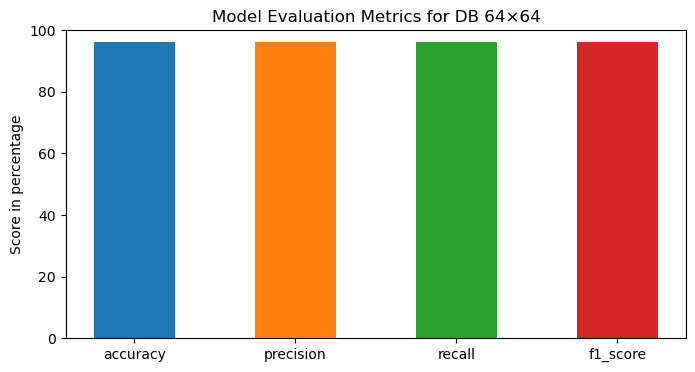

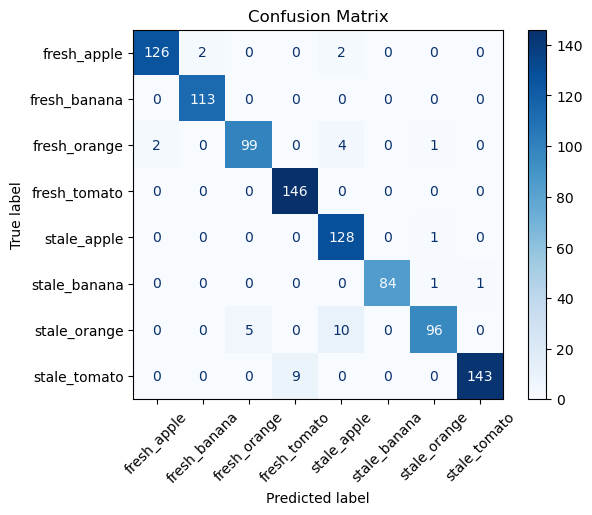

Trying to read previous results for DB 128×128
Were not able to read previous results, computing new ones for DB 128×128
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/cesar/.conda/envs/academy/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cesar/.conda/envs/academy/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cesar/.conda/envs/academy/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [ ]:
test_scores = {}
for name, path in DB_DICT.items():
    _, _, test_score = main(name, path)
    test_scores[name] = test_score

In [8]:
def plot_grouped_metrics(metrics_dict: dict[str, dict[str, float]]) -> None:
    """
    Plots the evaluation metrics of multiple databases in a grouped bar plot.

    Args:
        metrics_dict (dict[str, dict[str, float]]):
            A dictionary where the keys are database names and the values are dictionaries of metrics.

    Returns:
        None
    """
    # Extract database names and metric names
    db_names = list(metrics_dict.keys())
    metric_names = list(next(iter(metrics_dict.values())).keys())

    # Create data for plotting
    n_dbs = len(db_names)
    n_metrics = len(metric_names)
    width = 0.1  # Width of each bar

    # Define the x positions for the groups of bars
    x = np.arange(n_dbs)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each metric for each database
    for i, metric in enumerate(metric_names):
        values = [
            metrics_dict[db][metric] * 100 for db in db_names
        ]  # Convert to percentage
        ax.bar(x + i * width, values, width, label=metric.capitalize())

    # Customize the plot
    ax.set_xlabel("Databases")
    ax.set_ylabel("Score in Percentage")
    ax.set_title("Comparison of Evaluation Metrics Across Databases")
    ax.set_xticks(x + width * (n_metrics - 1) / 2)
    ax.set_xticklabels(db_names)
    ax.legend(title="Metrics", loc="lower center")
    plt.ylim(95, 100)

    plt.show()

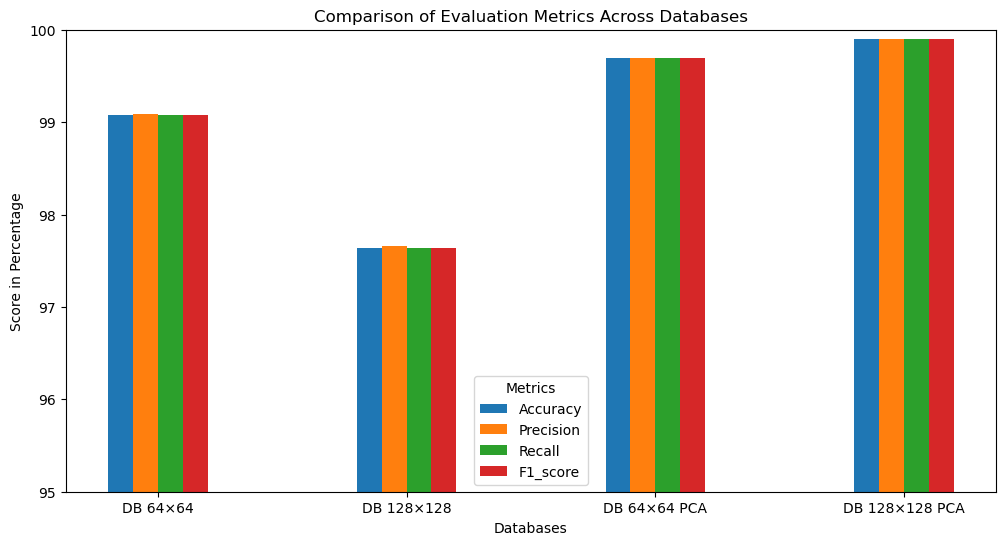

In [9]:
plot_grouped_metrics(test_scores)

## Conclusiones
1. La característica de los histogramas de gradientes orientados (HOG) resultó útil para hallar las formas de los objetos en las imágenes, esto es especialmente significativo para la tarea de distinguir algunas frutas, por ejemplo de la forma elongada de una banana contra la forma circular de una naranja.
2. La característica de patrones binarios locales (LBP) sirvió para caracterizar las texturas presentes en las imágenes, siendo especialmente útil en las imágenes de "alta" resolución (128×128), ya que en las de baja resolución (64×64) se distorsiona demasiado.
3. Esta misma característica además permite visualizar las frutas, ya que algo tienen en común los fondos y es que son relativamente uniformes en textura, a diferencia de las frutas.
4. Mediante el análisis de histogramas de las componentes en el espacio Hue-Saturation-Value (HSV) se obtuvieron características adicionales que permiten aprovechar la diferencia en matiz, saturación y luminosidad de las imágenes, las cuales a simple vista otorgan información valiosa para la tarea de clasificación.